<a href="https://colab.research.google.com/github/MansourMhz/MansourMhz/blob/main/17011401_BTC_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/MasterThesis/BTCUSD_Candlestick_5_M_BID_28.03.2022-02.04.2022.csv')

In [4]:
dataset.head(10)

,Local time,Open,High,Low,Close,Volume
0,28.03.2022 00:00:00.000 GMT+0430,44836,44843,44804,44808,0.0025
1,28.03.2022 00:05:00.000 GMT+0430,44808,44838,44793,44834,0.0020
2,28.03.2022 00:10:00.000 GMT+0430,44833,44840,44788,44789,0.0022
3,28.03.2022 00:15:00.000 GMT+0430,44790,44804,44782,44798,0.0014
4,28.03.2022 00:20:00.000 GMT+0430,44798,44819,44785,44801,0.0016
5,28.03.2022 00:25:00.000 GMT+0430,44801,44807,44779,44794,0.0020
6,28.03.2022 00:30:00.000 GMT+0430,44794,44815,44773,44777,0.0019
7,28.03.2022 00:35:00.000 GMT+0430,44775,44793,44769,44769,0.0015
8,28.03.2022 00:40:00.000 GMT+0430,44769,44773,44730,44748,0.0013
9,28.03.2022 00:45:00.000 GMT+0430,44749,44763,44727,44741,0.0014


In [5]:
num_train = int(dataset.shape[0]*0.70)
training_set = dataset.iloc[0:num_train,4].values#Close
testing_set = dataset.iloc[num_train:,4].values#Close
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1)) # training
testing_set_scaled = sc.fit_transform(testing_set.reshape(-1,1)) #testing
timestep = 60
X_train =[]
Y_train =[]
for i in range(timestep,len(training_set)):   #Train
    X_train.append(training_set_scaled[i-timestep:i,0]) #
    Y_train.append(training_set_scaled[i,0])
x_train = np.array(X_train)
y_train = np.array(Y_train)
X_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
Y_train = np.reshape(y_train,(y_train.shape[0],1))
X_test = []
Y_test =[]
for i in range(timestep,len(testing_set)):    #TEST
    X_test.append(testing_set_scaled[i-timestep:i,0])
    Y_test.append(testing_set_scaled[i,0])
x_test = np.array(X_test)
y_test = np.array(Y_test)
X_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
Y_test = np.reshape(y_test,(y_test.shape[0],1))
x_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(Y_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(Y_test).type(torch.Tensor)
input_dim = 1 #  60 lstm  1 day
hidden_dim = 30
num_layers = 2
output_dim = 1 # 60 lstm 1 day

In [6]:
class MyLSTM(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers,output_dim):
        super(MyLSTM,self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,num_layers, batch_first = True) #1 -- 32

        self.fc = torch.nn.Linear(hidden_dim, output_dim) #32 --- 1
        self.sf = torch.nn.Sigmoid() #0,1
        #self.sf = torch.nn.ReLU()
        #self.sf = torch.nn.Tanh()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()   #hidden state matrix zero with grad
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm (x, (h0.detach(),c0.detach()))
        out = self.fc(out[:,-1,:]) # block hidd feature
        out = self.sf(out)

        return out

In [7]:
model = MyLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

In [8]:
#loss_fn = torch.nn.MSELoss() #l2score l1score #smooth MSE #huber

loss_fn = torch.nn.L1Loss() # best 1
#loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = torch.nn.NLLLoss()
# loss_fn = torch.nn.SmoothL1Loss()

# loss_fn = torch.nn.HuberLoss() # best 2

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

#train model

In [9]:
num_epoch = 100
listLoss = np.zeros(num_epoch)

In [10]:
for t in range(num_epoch):

    y_train_pred = model(x_train) # forward(self,x) inputs
    loss = loss_fn(y_train_pred , y_train) #loss
    listLoss[t] = loss.item() #save loss in list
    #print("epoch:",t,  "loss", loss.item()) #print lossepoch
    optimizer.zero_grad() #
    loss.backward() #
    optimizer.step() # update

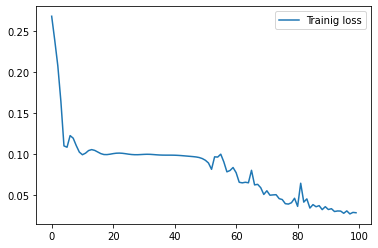

In [11]:
plt.plot(listLoss, label ="Trainig loss")
plt.legend()
plt.show()

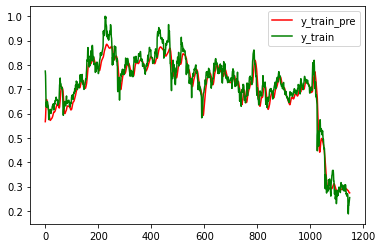

In [12]:
plt.plot(y_train_pred.detach().numpy(), label ="y_train_pre", color ='red')
plt.plot(y_train.detach().numpy(), label ="y_train", color ='green')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import r2_score
r2_score = r2_score(y_train.detach().numpy(), y_train_pred.detach().numpy())
r2_score

0.9374671877832965

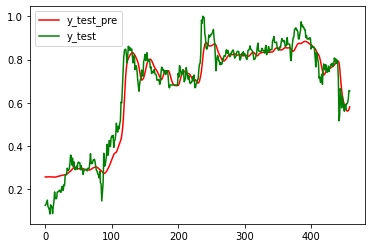

In [14]:
y_test_pred = model(x_test)
plt.plot(y_test_pred.detach().numpy(), label ="y_test_pre", color ='red')
plt.plot(y_test.detach().numpy(), label ="y_test", color ='green')
plt.legend()
plt.show()

In [15]:
a = y_test_pred.detach().numpy()
b = y_test.detach().numpy()

In [16]:
q1 = a[0:50]
q2 = a[50:100]
q3 = a[100:150]
q4 = a[150:200]
q5 = a[200:250]
q6 = a[250:300]
q7 = a[300:]

In [17]:
w1 = b[0:50]
w2 = b[50:100]
w3 = b[100:150]
w4 = b[150:200]
w5 = b[200:250]
w6 = b[250:300]
w7 = b[300:]

In [19]:
trend = ""
if (q1[0]<q1[len(q1)-1]):
  trend = "positive trend"
else:
  trend = "negative trend"
trend


'positive trend'

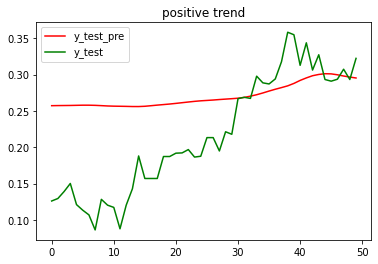

In [20]:
plt.plot(q1, label ="y_test_pre", color ='red')
plt.plot(w1, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()

In [21]:
trend = ""
if (q1[0]<q1[len(q1)-1]):
    trend = "positive trend"
else:
  trend = "negative trend"

trend

'positive trend'

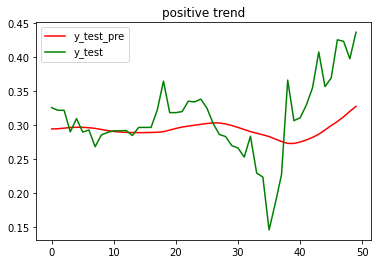

In [22]:
plt.plot(q2, label ="y_test_pre", color ='red')
plt.plot(w2, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()

In [23]:
if (q3[0]<q3[len(q3)-1]):
    trend = "positive trend"

else:
    trend = "negative trend"
trend

'positive trend'

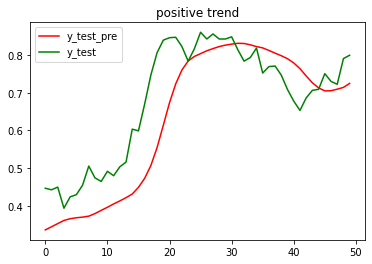

In [24]:
plt.plot(q3, label ="y_test_pre", color ='red')
plt.plot(w3, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()

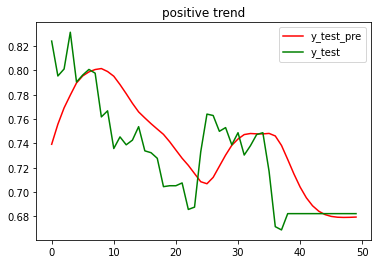

In [25]:
plt.plot(q4, label ="y_test_pre", color ='red')
plt.plot(w4, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()

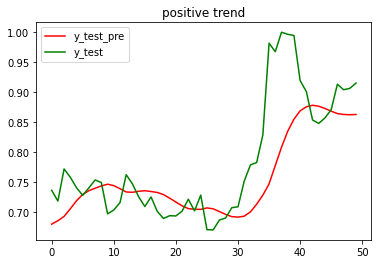

In [26]:
plt.plot(q5, label ="y_test_pre", color ='red')
plt.plot(w5, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()


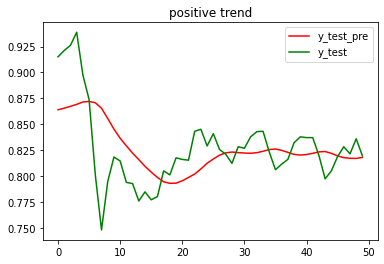

In [27]:
plt.plot(q6, label ="y_test_pre", color ='red')
plt.plot(w6, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()

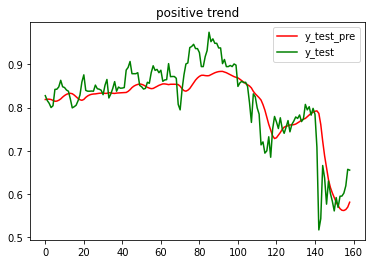

In [28]:
plt.plot(q7, label ="y_test_pre", color ='red')
plt.plot(w7, label ="y_test", color ='green')
plt.title(trend)
plt.legend()
plt.show()

In [29]:
y_test_pred = y_test_pred.detach().numpy()
y_test = y_test.detach().numpy()

In [30]:
import sklearn
r2_score = sklearn.metrics.r2_score(y_test, y_test_pred)
r2_score

0.9337914701992346

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error # Error
mean_absolute_error = mean_absolute_error(y_train.detach().numpy(), y_train_pred.detach().numpy())
mean_absolute_error

0.028837241

In [32]:
mean_squared_error = mean_squared_error(y_train.detach().numpy(), y_train_pred.detach().numpy())
mean_squared_error
Root_mean_squared_error = np.sqrt(sklearn.metrics.mean_squared_error(y_train.detach().numpy(), y_train_pred.detach().numpy()))
Root_mean_squared_error

0.03804138